In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/응용통계학과 공모전')

# 요약
1. 군집별 워드클라우드 시각화
2. 사용자의 경험, 역량과 채용공고를 비교하여 필요한 역량을 제안하기 위한 키워드 도출  
2-1) BERTopic  
BERTopic을 활용해 군집별 내재된 키워드 도출  
2-2) keyBERT  
keyBERT를 활용해 문맥을 고려하고 의미가 풍성한 키워드 도출
3. 군집별 중복 키워드 제거, 고유 인사이트 제공  
3-1) 사전학습된 생성형 AI 모델을 통해 사용자에게 필요한 역량을 제안

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tqdm import tqdm

# WordCloud

빈도 50회 이상, 1글자 제거

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths=None, fontext='otf')
# font_list

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

In [ ]:
df_noun = pd.read_csv('./data/final_noun_df.csv')
df_noun.head(3)

,직무,nouns,kmeans_label
0,머신러닝 엔지니어,언어,2
1,머신러닝 엔지니어,성능,2
2,머신러닝 엔지니어,고도화,2


In [ ]:
# colab 한글 폰트

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
grouped_data = df_noun.groupby('kmeans_label')['nouns'].apply(' '.join)

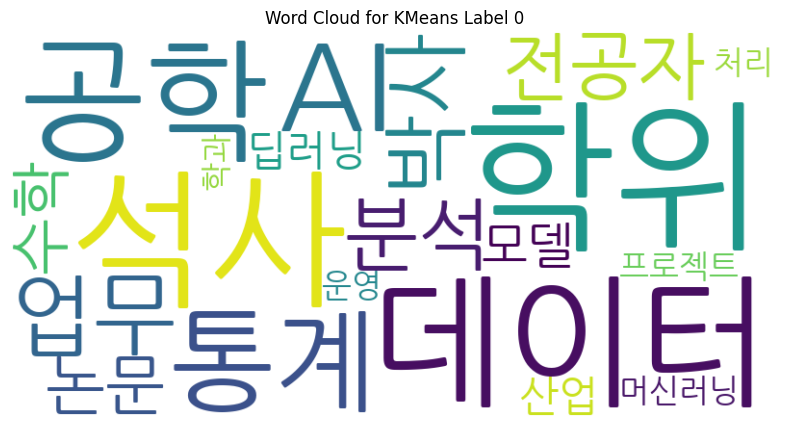

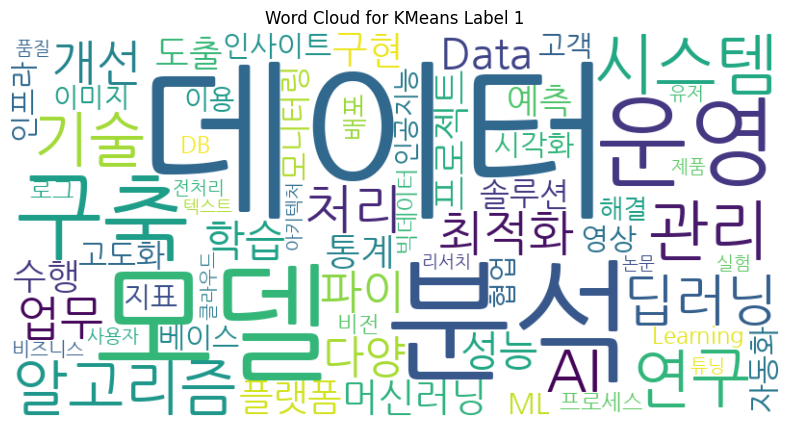

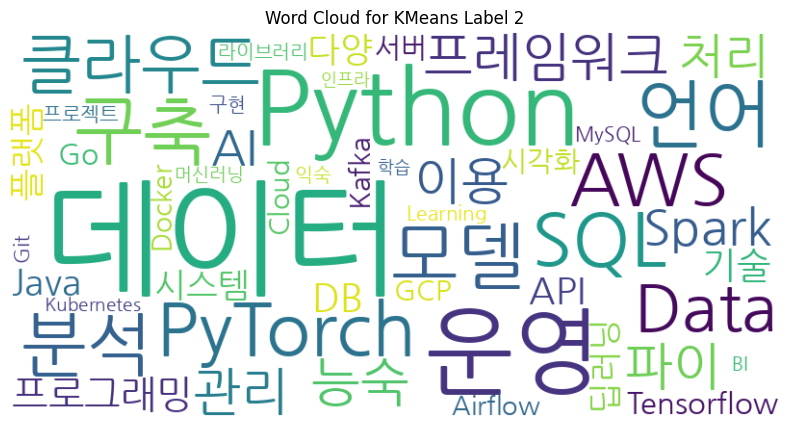

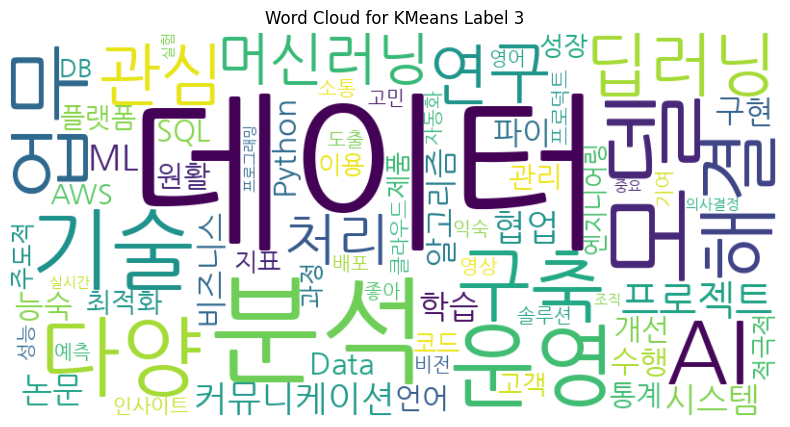

In [ ]:
# Word Cloud
for label, sentences in grouped_data.items():

    words = sentences.split()
    filtered_words = [word for word in words if len(word) > 1 and words.count(word) > 50]

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=False,
        font_path=path,).generate(' '.join(filtered_words))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for KMeans Label {label}')
    plt.show()

# BERTopic
군집내 키워드 추출을 위해 BERTopic을 활용하고자 토픽의 수를 2로 설정

토픽수 1로 지정하면 오류발생  
B)BERTopic은 이상치 군집(-1)이 무조건 하나 만들어져야함  

In [ ]:
!pip install transformers
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 50.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039196 sha256=5106fa1817ec322ec13f1241d0e89109672982bd7eadfea80d863d7a1b0d2ecd
  Stored in dire

In [ ]:
from transformers import AutoTokenizer, AutoModel
from bertopic import BERTopic
import torch

In [ ]:
df_0 = df_noun[df_noun['kmeans_label']==0]
df_1 = df_noun[df_noun['kmeans_label']==1]
df_2 = df_noun[df_noun['kmeans_label']==2]
df_3 = df_noun[df_noun['kmeans_label']==3]

In [ ]:
df_0.head(3)

,직무,nouns,kmeans_label
18,머신러닝 엔지니어,AI,0
19,머신러닝 엔지니어,ML,0
20,머신러닝 엔지니어,등,0


### df_0

In [ ]:
num_topics = 2

topic_model = BERTopic(language='korean', nr_topics=num_topics)
topics, _ = topic_model.fit_transform(df_0['nouns'])

topic_info = topic_model.get_topic_info()

# 군집별 키워드 상위 10개 키워드추출
representative_keywords = topic_model.get_topics()

df_0_keywords = representative_keywords[0]

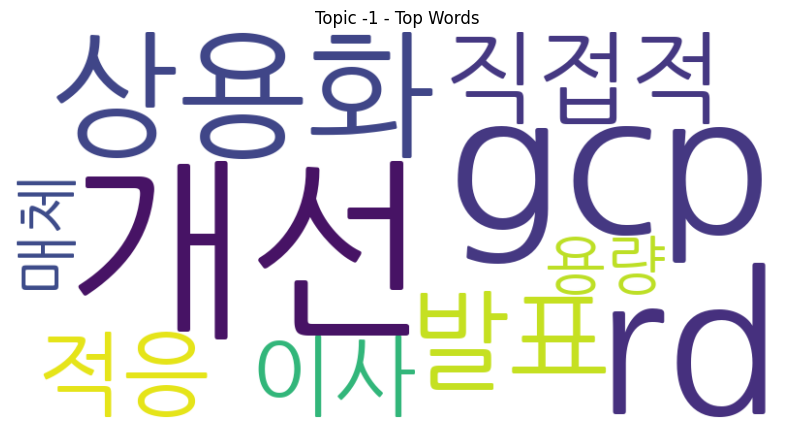

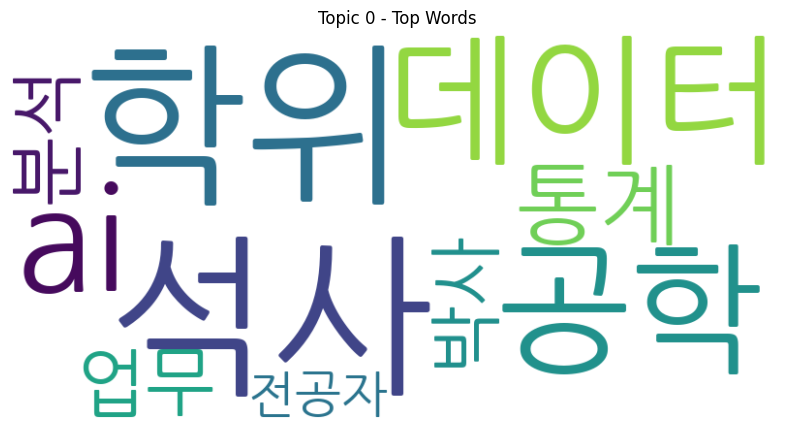

In [ ]:
for topic_id in range(-1,-1 + topic_model.nr_topics):

    representation_values = topic_info.loc[topic_info['Topic'] == topic_id, 'Representation'].values[0]
    representation_str = ", ".join(representation_values)[:100]

    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=path).generate(representation_str)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id} - Top Words")
    plt.show()

## df_1

In [ ]:
num_topics = 2

topic_model = BERTopic(language='korean', nr_topics=num_topics)
topics, _ = topic_model.fit_transform(df_1['nouns'])

topic_info = topic_model.get_topic_info()

# 군집별 키워드 상위 10개 키워드추출
representative_keywords = topic_model.get_topics()

df_1_keywords = representative_keywords[0]

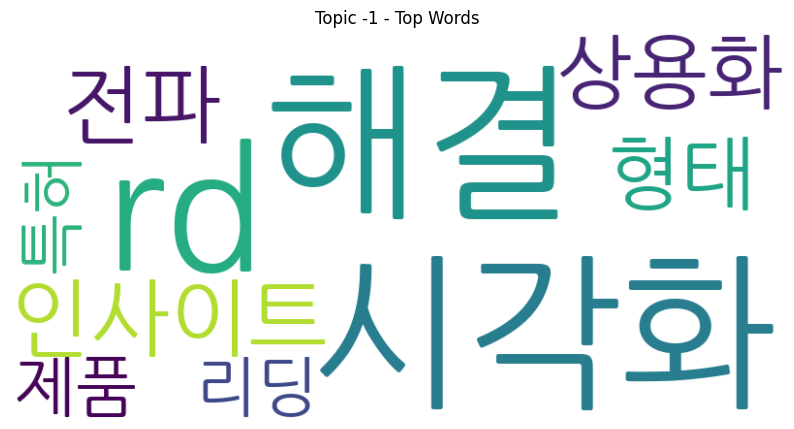

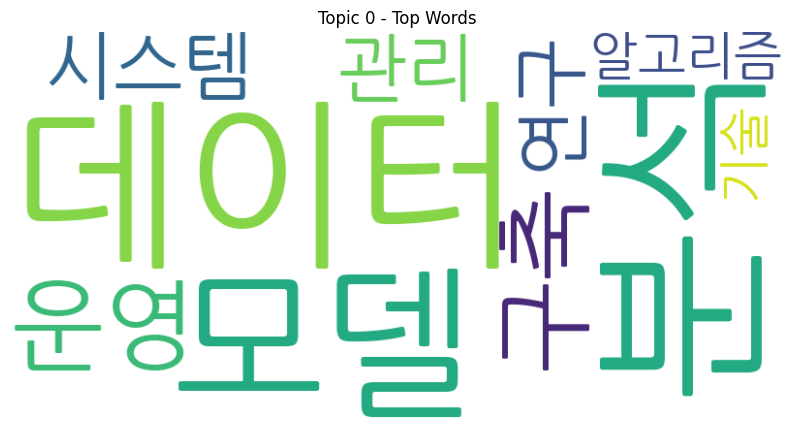

In [ ]:
for topic_id in range(-1,-1 + topic_model.nr_topics):

    representation_values = topic_info.loc[topic_info['Topic'] == topic_id, 'Representation'].values[0]
    representation_str = ", ".join(representation_values)[:100]

    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=path).generate(representation_str)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id} - Top Words")
    plt.show()

## df_2

In [ ]:
num_topics = 2

topic_model = BERTopic(language='korean', nr_topics=num_topics)
topics, _ = topic_model.fit_transform(df_2['nouns'])

topic_info = topic_model.get_topic_info()

# 군집별 키워드 상위 10개 키워드추출
representative_keywords = topic_model.get_topics()

df_2_keywords = representative_keywords[0]

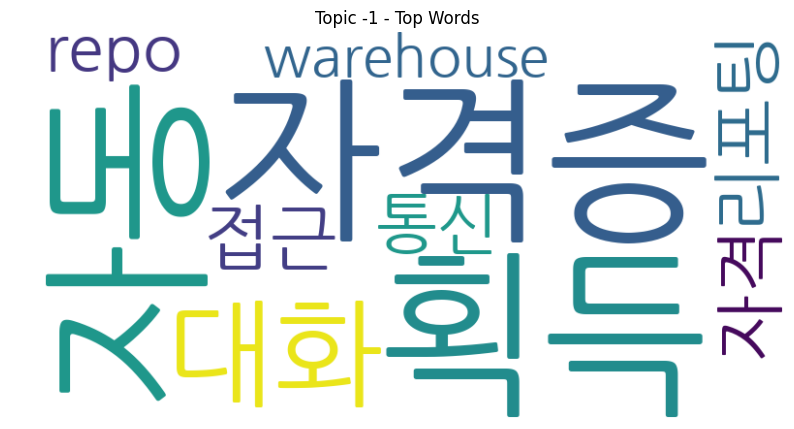

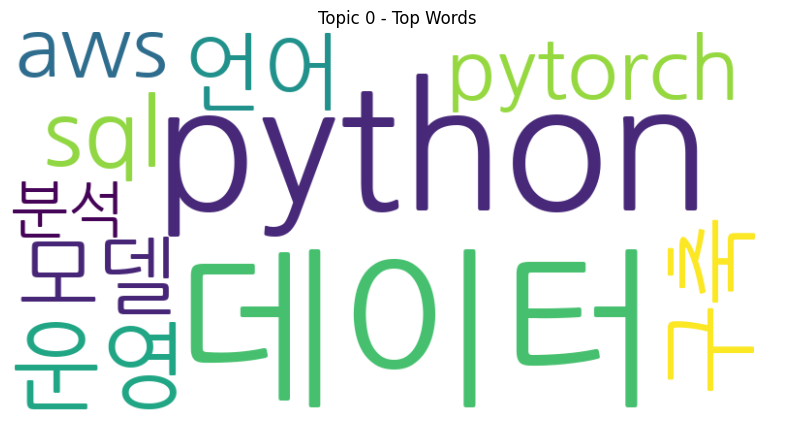

In [ ]:
for topic_id in range(-1,-1 + topic_model.nr_topics):

    representation_values = topic_info.loc[topic_info['Topic'] == topic_id, 'Representation'].values[0]
    representation_str = ", ".join(representation_values)[:100]

    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=path).generate(representation_str)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id} - Top Words")
    plt.show()

## df_3

In [ ]:
num_topics = 2

topic_model = BERTopic(language='korean', nr_topics=num_topics)
topics, _ = topic_model.fit_transform(df_3['nouns'])

topic_info = topic_model.get_topic_info()

# 군집별 키워드 상위 10개 키워드추출
representative_keywords = topic_model.get_topics()

df_3_keywords = representative_keywords[0]

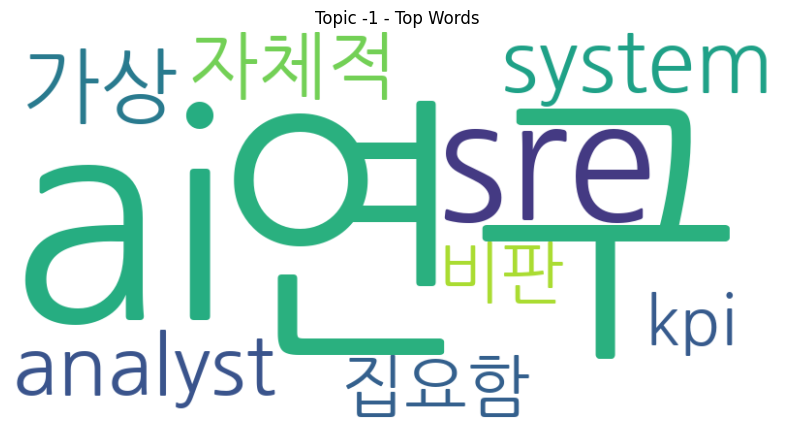

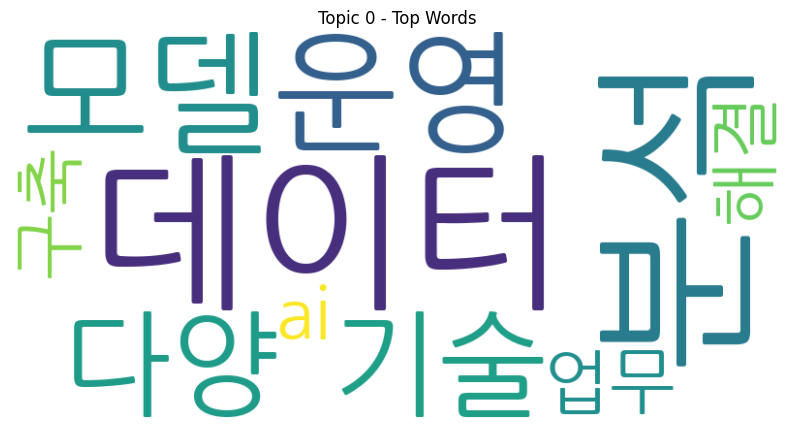

In [ ]:
for topic_id in range(-1,-1 + topic_model.nr_topics):

    representation_values = topic_info.loc[topic_info['Topic'] == topic_id, 'Representation'].values[0]
    representation_str = ", ".join(representation_values)[:100]

    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=path).generate(representation_str)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id} - Top Words")
    plt.show()

In [ ]:
BERTopic_keyword = pd.DataFrame()

df_list = [df_0_keywords, df_1_keywords, df_2_keywords, df_3_keywords]
column_list = ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']

# 데이터프레임 형태로 변환
for idx, df_keyword in enumerate(df_list):
    keyword_list = [BERTopic_keyword for BERTopic_keyword, ratio in df_keyword]
    df = pd.DataFrame(keyword_list, columns=[column_list[idx]])
    BERTopic_keyword = pd.concat([BERTopic_keyword, df], axis=1)

BERTopic_keyword

,Cluster0,Cluster1,Cluster2,Cluster3
0,학위,데이터,데이터,데이터
1,석사,분석,python,분석
2,데이터,모델,운영,모델
3,공학,운영,sql,운영
4,ai,구축,구축,기술
5,통계,시스템,pytorch,다양
6,업무,관리,언어,ai
7,박사,연구,모델,구축
8,분석,알고리즘,aws,해결
9,전공자,기술,분석,업무


In [ ]:
# BERTopic_keyword.to_csv("./data/BERTopic_keyword.csv", index=False)

# keyBERT

In [ ]:
!pip install keybert

  Preparing metadata (setup.py) ... done
  Created wheel for keybert: filename=keybert-0.8.3-py3-none-any.whl size=39126 sha256=80c2468ec88dfdf84a41d11910a6a6e0723c3d9cd0fbc751edce72b165e8e9d4
  Stored in directory: /root/.cache/pip/wheels/70/88/07/1a3bc11fd1dd5f89924a02dcbca89a3015e25e8faa31f904dc
Successfully built keybert


In [ ]:
from keybert import KeyBERT

## 1) 문장 활용 키워드 추출
- 문장 활용을 통해선 유의미한 키워드 추출이 어려움을 확인

In [ ]:
df_sentence = pd.read_csv('./data/final_sentence_df.csv')
df_sentence.head(1)

,index,공고명,직무,유사 직무,업종,회사명,주요업무,자격요건,우대사항,nouns,sentence,vector,kmeans_label
0,0,"AI, ML Engineer 박사급",머신러닝 엔지니어,"데이터 엔지니어,머신러닝 엔지니어","IT, 컨텐츠",플리토,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분 ML 프레...",모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이...,"['언어', '성능', '고도화']",기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다,"[0.03565007075667381, -0.7653368711471558, 0.3...",2


In [ ]:
# kmeans_label을 기준으로 그룹화하여 sentence를 합침
result_sentence = df_sentence.groupby('kmeans_label')['sentence'].apply(lambda x: ' '.join(x)).reset_index()
result_sentence

,kmeans_label,sentence
0,0,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분 웬만한 중견..."
1,1,기업 고객에게 필요한 LLM 학습 데이터 구축 가이드라인 수립 및 사내 데이터 구축...
2,2,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...
3,3,LLM 학습 및 finetuning을 통해 내부적으로 필요한 LLM 개발을 진행합니...


In [ ]:
kw_model = KeyBERT()

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
# 키워드 개수 설정
n=10

# KeyBERT 파라미터 설정
keywords_mmr = kw_model.extract_keywords(result_sentence.sentence[0],
                                         keyphrase_ngram_range=(1,1),
                                         use_mmr = True,
                                         top_n = n,
                                         diversity = 0.4,
                                         stop_words = [])

keywords_mmr

[('금융자격증투자자산운용사', 0.4647),
 ('책임의식', 0.3451),
 ('ai기반', 0.3131),
 ('ai', 0.2716),
 ('20일', 0.2587),
 ('econometrics', 0.2094),
 ('fluency', 0.1795),
 ('uncertainty', 0.1697),
 ('techniques', 0.1636),
 ('semiprofessional', 0.1091)]

In [ ]:
# 키워드 개수 설정
n=10

# KeyBERT 파라미터 설정
keywords_mmr = kw_model.extract_keywords(result_sentence.sentence[1],
                                         keyphrase_ngram_range=(1,1),
                                         use_mmr = True,
                                         top_n = n,
                                         diversity = 0.4,
                                         stop_words = [])

keywords_mmr

[('비정형데이터파이프라인구축', 0.5859),
 ('화질평가결과분석', 0.553),
 ('분산환경의', 0.5449),
 ('국제공인시험성적서', 0.5332),
 ('생산협력업체', 0.5146),
 ('업데이트고도화', 0.4941),
 ('소셜미디어의', 0.4412),
 ('수의사와의', 0.3429),
 ('llm', 0.1416),
 ('flywheel', 0.0695)]

In [ ]:
# 키워드 개수 설정
n=10

# KeyBERT 파라미터 설정
keywords_mmr = kw_model.extract_keywords(result_sentence.sentence[2],
                                         keyphrase_ngram_range=(1,1),
                                         use_mmr = True,
                                         top_n = n,
                                         diversity = 0.4,
                                         stop_words = [])

keywords_mmr

[('데이터센터인프라개발경험', 0.4729),
 ('운영환경', 0.4326),
 ('이미지생성모델karlo과', 0.3857),
 ('ai사업부의', 0.3463),
 ('일련의', 0.3072),
 ('cloudfront등의', 0.2428),
 ('performance', 0.2425),
 ('tensorflow와', 0.2152),
 ('augmentation', 0.1618),
 ('xaiexplainable', 0.1133)]

## 1) 명사 활용 키워드 추출

In [ ]:
# kmeans_label을 기준으로 그룹화하여 noun를 합침
result_noun = df_noun.groupby('kmeans_label')['nouns'].apply(lambda x: ' '.join(x)).reset_index()
result_noun

,kmeans_label,nouns
0,0,AI ML 등 박사 학위 정직 원 석사 박사 이사 회 개인 비용 비용 정직 원 정직...
1,1,고객 LLM 학습 데이터 구축 가이드 데이터 구축 소프트웨어 LLM 모델 연구 고도...
2,2,언어 성능 고도화 프레임워크 자신 AWS 등 클라우드 이용 Github 공개 프로젝...
3,3,LLM 학습 finetuning LLM AI ML 방향성 모델 공개 모델 finet...


In [ ]:
# 키워드 개수 설정
n=20

# KeyBERT 파라미터 설정
keywords_0 = kw_model.extract_keywords(result_noun.nouns[0],
                                         keyphrase_ngram_range=(1,1),
                                         use_mmr = True,
                                         top_n = n,
                                         diversity = 0.4,
                                         stop_words = ['교육', '참여', '의식', '구축', '마인드', '학습'])

In [ ]:
# 키워드 개수 설정
n=20

# KeyBERT 파라미터 설정
keywords_1 = kw_model.extract_keywords(result_noun.nouns[1],
                                         keyphrase_ngram_range=(1,1),
                                         use_mmr = True,
                                         top_n = n,
                                         diversity = 0.4,
                                         stop_words = ['팀들', '계산', '추구', '로드', '효과', '관계자', '수치', '비교', '흐름', '긴밀', '도움', '효율', '외국어', '마인드', '리뷰', '지표', '후보', '후처리', '참여'])

In [ ]:
# 키워드 개수 설정
n=20

# KeyBERT 파라미터 설정
keywords_2 = kw_model.extract_keywords(result_noun.nouns[2],
                                         keyphrase_ngram_range=(1,1),
                                         use_mmr = True,
                                         top_n = n,
                                         diversity = 0.4,
                                         stop_words = ['음악', '음식', '이슈', '학습', '유사'])

In [ ]:
# 키워드 개수 설정
n=20

# KeyBERT 파라미터 설정
keywords_3 = kw_model.extract_keywords(result_noun.nouns[3],
                                         keyphrase_ngram_range=(1,1),
                                         use_mmr = True,
                                         top_n = n,
                                         diversity = 0.4,
                                         stop_words = ['구축', '비교', '사람들', '팀들', '급여', '분들', '마인드', '출시', '팀원들', '습득', '효과', '추구', '도움', '효율', '참여', '검사', '관심'])

In [ ]:
keyBERT_keyword = pd.DataFrame()

df_list = [keywords_0, keywords_1, keywords_2, keywords_3]
column_list = ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']

# 데이터프레임 형태로 변환
for idx, df_keyword in enumerate(df_list):
    keyword_list = [keyBERT_keyword for keyBERT_keyword, ratio in df_keyword]
    df = pd.DataFrame(keyword_list, columns=[column_list[idx]])
    keyBERT_keyword = pd.concat([keyBERT_keyword, df], axis=1)

keyBERT_keyword

,Cluster0,Cluster1,Cluster2,Cluster3
0,의사결정,의사결정,오케스트레이션,의사결정
1,ai,시선추적,tensorflow,검색엔진
2,오케스트레이션,검색엔진,java,시뮬레이션
3,빅데이터,머신러닝,docker,오케스트레이션
4,신입,학습데이터,텍스트,빅데이터
5,engine,아이디어,정형화,아이디어
6,ml,오케스트레이션,gpu,ai
7,research,리서치,pipeline,극대화
8,mlops,데이터베이스,aws,ml
9,tensorflow,유의미,airflow,llm


In [ ]:
# keyBERT_keyword.to_csv("./data/keyBERT_keyword.csv", index=False)

# Cluster별 keyword extration
- 서로 다른 keyword 추출 알고리즘을 함께 사용하여 Cluster를 대표하는 키워드를 찾아내는데 있어 다양성을 고려
  
#### 과정
1. BERTopic에서 추출한 키워드와 keyBERT에서 추출한 키워드 병합
2. 각 Cluster의 중복 키워드 제거
3. Cluster별 중복 키워드 제거(3 Cluster 이상 중복)

In [ ]:
BERTopic_keyword = pd.read_csv("./data/BERTopic_keyword.csv")
keyBERT_keyword = pd.read_csv("./data/keyBERT_keyword.csv")

In [ ]:
# 1. BERTopic에서 추출한 키워드와 keyBERT에서 추출한 키워드 병합
keyword_df = pd.concat([BERTopic_keyword, keyBERT_keyword], axis = 0)
keyword_df.reset_index(drop=True, inplace=True)

In [ ]:
# 2. 각 Cluster의 중복 키워드 제거
for column in keyword_df.columns:
  keyword_df[column] = keyword_df[column].drop_duplicates()

In [ ]:
# 3. Cluster별 중복 키워드 제거(3 Cluster 이상 중복)

# keyword 전체를 한개의 리스트로 병합
keyword_list = [item for sublist in [keyword_df[column].dropna().tolist() for column in keyword_df.columns] for item in sublist]
len(keyword_list)

116

In [ ]:
# value_count()를 통해 3개 이상의 군집에서 중복으로 나오는 키워드 확인
keyword_series = pd.Series(keyword_list)

value_counts = keyword_series.value_counts()
more3_keywords = value_counts[value_counts >= 3].index.tolist()

In [ ]:
# more3_keywords에 해당하는 값 제거
cluster0 = keyword_df.iloc[:,0].tolist()
cluster1 = keyword_df.iloc[:,1].tolist()
cluster2 = keyword_df.iloc[:,2].tolist()
cluster3 = keyword_df.iloc[:,3].tolist()

cluster0 = [value for value in cluster0 if value not in more3_keywords]
cluster0 = [value for value in cluster0 if not (isinstance(value, float) and math.isnan(value))]
cluster1 = [value for value in cluster1 if value not in more3_keywords]
cluster1 = [value for value in cluster1 if not (isinstance(value, float) and math.isnan(value))]
cluster2 = [value for value in cluster2 if value not in more3_keywords]
cluster2 = [value for value in cluster2 if not (isinstance(value, float) and math.isnan(value))]
cluster3 = [value for value in cluster3 if value not in more3_keywords]
cluster3 = [value for value in cluster3 if not (isinstance(value, float) and math.isnan(value))]

In [6]:
cluster0_df = pd.DataFrame({"Cluster0": cluster0})
cluster1_df = pd.DataFrame({"Cluster1": cluster1})
cluster2_df = pd.DataFrame({"Cluster2": cluster2})
cluster3_df = pd.DataFrame({"Cluster3": cluster3})

keyword_df = pd.concat([cluster0_df ,cluster1_df, cluster2_df, cluster3_df], axis=1)
keyword_df

,Cluster0,Cluster1,Cluster2,cluster3
0,분석,시스템,python,기술
1,통계,관리,sql,업무
2,research,연구,pytorch,해결
3,빅데이터,알고리즘,언어,검색엔진
4,ml,query,aws,프로젝트
5,logic,llm,server,빅데이터
6,mlops,트렌드,java,아이디어
7,논문,기계학습,docker,극대화
8,tensorflow,mlops,텍스트,ml
9,lab,sdk,정형화,llm


In [ ]:
# cluster0_df.to_csv("./data/cluster0.csv", index=False)
# cluster1_df.to_csv("./data/cluster1.csv", index=False)
# cluster2_df.to_csv("./data/cluster2.csv", index=False)
# cluster3_df.to_csv("./data/cluster3.csv", index=False)

# keyword_df.to_csv("./data/keyword_df.csv", index=False)

# Cluster별 직무 수

In [ ]:
df_sentence = pd.read_csv("./data/final_sentence_df.csv")
df_sentence.groupby('kmeans_label')['직무'].value_counts()

kmeans_label  직무        
0             머신러닝 엔지니어      941
              데이터 엔지니어       843
              데이터 사이언티스트     487
              빅데이터 엔지니어      347
              DBA            137
              BI 엔지니어         36
1             데이터 엔지니어      1499
              머신러닝 엔지니어     1252
              데이터 사이언티스트     772
              빅데이터 엔지니어      610
              DBA            190
              BI 엔지니어         84
2             데이터 엔지니어      1157
              머신러닝 엔지니어      918
              데이터 사이언티스트     435
              빅데이터 엔지니어      426
              DBA            157
              BI 엔지니어         52
3             데이터 엔지니어      1871
              머신러닝 엔지니어     1548
              데이터 사이언티스트    1009
              빅데이터 엔지니어      734
              DBA            192
              BI 엔지니어         74
Name: 직무, dtype: int64